In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

In [3]:
# Load the dataset
file_path = "datasets/Processed_Dataset_adding_priceMovementLabel.csv"  # Replace with the path to your CSV file
data = pd.read_csv(file_path)

# Parse relevant columns for all bid and ask levels
levels = 5  # Number of bid/ask levels
bid_columns = [f"bids[{i}].price" for i in range(levels)] + [f"bids[{i}].amount" for i in range(levels)]
ask_columns = [f"asks[{i}].price" for i in range(levels)] + [f"asks[{i}].amount" for i in range(levels)]
feature_columns = bid_columns + ask_columns

split_index = int(len(data) * 0.9)
actual_data = data.iloc[split_index+1:].copy(deep=True)

# Create target variable (predict next mark_price)
data["target"] = data["mark_price"].shift(-1)  # Predict next mark_price (shift by -1)


# Sequentially split data into train (60%), test (30%), and eval (10%)
train_size = int(len(data) * 0.6)
test_size = int(len(data) * 0.3)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:train_size + test_size+1]
eval_data = data.iloc[train_size + test_size+1:].copy()  # Copy to avoid SettingWithCopyWarning


# Features and target
X_eval = eval_data[feature_columns]
y_eval = eval_data["target"]

In [4]:
adaboost_model = joblib.load("ML/adaboost_model.pkl")
lr_model = joblib.load("ML/lr_model.pkl")


In [5]:
# Predict on the evaluation set
eval_data.loc[:, "predicted_lr"] = lr_model.predict(X_eval)
eval_data.loc[:, "predicted_adaboost"] = adaboost_model.predict(X_eval)

In [6]:
# Evaluate performance using MSE on evaluation set
mse_lr = mean_squared_error(y_eval, eval_data["predicted_lr"])
mse_adaboost = mean_squared_error(y_eval, eval_data["predicted_adaboost"])

print(f"Linear Regression MSE (Eval Set): {mse_lr:.2f}")
print(f"AdaBoost MSE (Eval Set): {mse_adaboost:.2f}")

Linear Regression MSE (Eval Set): 25.41
AdaBoost MSE (Eval Set): 1118.85


Directional Accuracy (Linear Regression): 29.83%
Directional Accuracy (AdaBoost): 23.47%


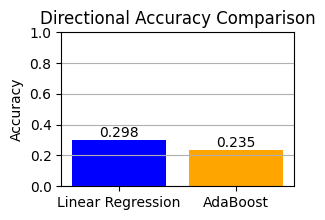

In [17]:
# Directional Accuracy
eval_data.loc[:, "actual_direction"] = np.sign(y_eval.diff().fillna(0))
eval_data.loc[:, "predicted_direction_lr"] = np.sign(eval_data["predicted_lr"] - y_eval)
eval_data.loc[:, "predicted_direction_adaboost"] = np.sign(eval_data["predicted_adaboost"] - y_eval)

# Calculate directional accuracy
directional_accuracy_lr = (eval_data["actual_direction"] == eval_data["predicted_direction_lr"]).mean()
directional_accuracy_adaboost = (eval_data["actual_direction"] == eval_data["predicted_direction_adaboost"]).mean()

print(f"Directional Accuracy (Linear Regression): {directional_accuracy_lr:.2%}")
print(f"Directional Accuracy (AdaBoost): {directional_accuracy_adaboost:.2%}")

# bar_width = 0.35

# Plot directional accuracy
labels = ["Linear Regression", "AdaBoost"]
values = [directional_accuracy_lr, directional_accuracy_adaboost]
# Report size
# plt.figure(figsize=(8, 5))
# Poster size
plt.figure(figsize=(3, 2))

bars=plt.bar(labels, values, color=["blue", "orange"])
plt.title("Directional Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y")

# Displaying the values on top of each bar
for bar in bars:
    height = bar.get_height()
    # plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    # Poster
    height_formatted = "{:.3g}".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2, height, height_formatted, ha='center', va='bottom')



plt.show()

Tolerance-Based Accuracy (Linear Regression): 80.95%
Tolerance-Based Accuracy (AdaBoost): 18.25%


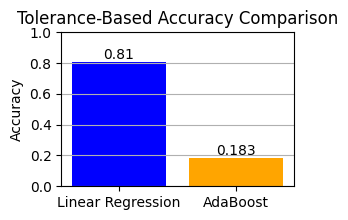

In [19]:
# Tolerance-Based Accuracy
tolerance = 0.0001 * y_eval.mean()  # Set tolerance to 0.01% of average price
eval_data.loc[:, "tolerance_lr"] = abs(eval_data["predicted_lr"] - y_eval) <= tolerance
eval_data.loc[:, "tolerance_adaboost"] = abs(eval_data["predicted_adaboost"] - y_eval) <= tolerance

# Calculate tolerance-based accuracy
tolerance_accuracy_lr = eval_data["tolerance_lr"].mean()
tolerance_accuracy_adaboost = eval_data["tolerance_adaboost"].mean()

print(f"Tolerance-Based Accuracy (Linear Regression): {tolerance_accuracy_lr:.2%}")
print(f"Tolerance-Based Accuracy (AdaBoost): {tolerance_accuracy_adaboost:.2%}")

# Plot tolerance-based accuracy
labels = ["Linear Regression", "AdaBoost"]
values = [tolerance_accuracy_lr, tolerance_accuracy_adaboost]

# Report size
# plt.figure(figsize=(8, 5))
# Poster size
plt.figure(figsize=(3, 2))

bars=plt.bar(labels, values, color=["blue", "orange"])
plt.title("Tolerance-Based Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y")

# Displaying the values on top of each bar
for bar in bars:
    height = bar.get_height()
    # plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    # Poster
    height_formatted = "{:.3g}".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2, height, height_formatted, ha='center', va='bottom')


plt.show()

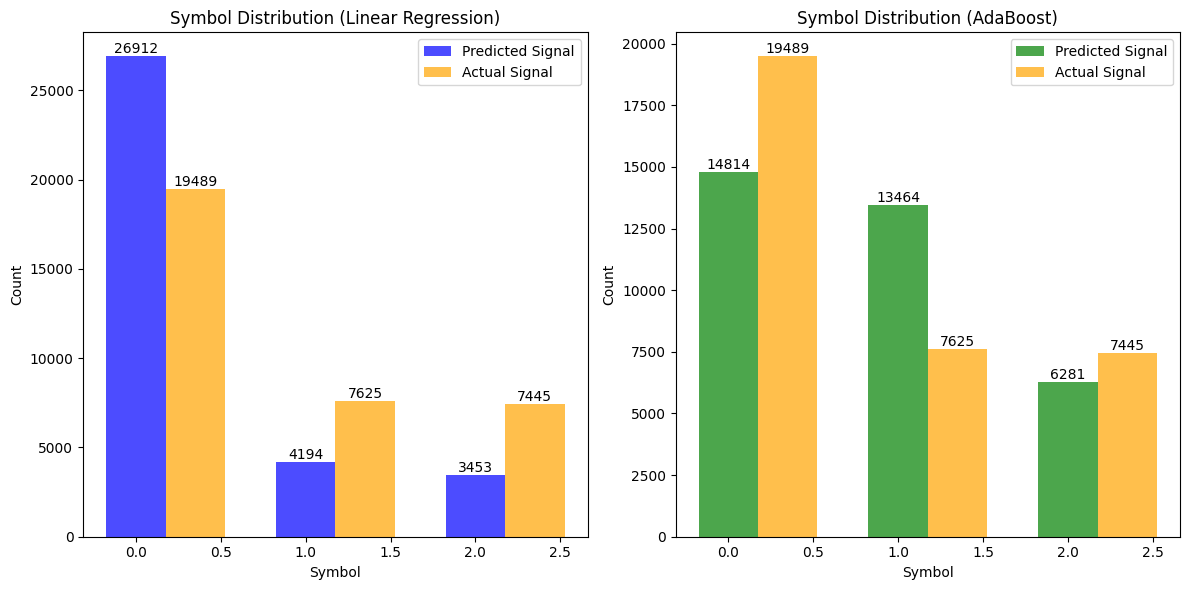

In [9]:
# Add symbol columns based on comparison with the last mark price
symbol_tolerance = 0.0001 * y_eval.mean()  # Adjust as needed
eval_data.loc[:, "symbol_lr"] = None
eval_data.loc[:, "symbol_adaboost"] = None

for i in range(1, len(eval_data)):
    # Get the last mark price
    last_mark_price = y_eval.iloc[i - 1]

    # Linear Regression symbol logic
    if eval_data["predicted_lr"].iloc[i] > last_mark_price + symbol_tolerance:
        eval_data.loc[eval_data.index[i], "symbol_lr"] = "up"
    elif eval_data["predicted_lr"].iloc[i] < last_mark_price - symbol_tolerance:
        eval_data.loc[eval_data.index[i], "symbol_lr"] = "down"
    else:
        eval_data.loc[eval_data.index[i], "symbol_lr"] = "stable"

    # AdaBoost symbol logic
    if eval_data["predicted_adaboost"].iloc[i] > last_mark_price + symbol_tolerance:
        eval_data.loc[eval_data.index[i], "symbol_adaboost"] = "up"
    elif eval_data["predicted_adaboost"].iloc[i] < last_mark_price - symbol_tolerance:
        eval_data.loc[eval_data.index[i], "symbol_adaboost"] = "down"
    else:
        eval_data.loc[eval_data.index[i], "symbol_adaboost"] = "stable"

# # Save the final evaluation DataFrame to a CSV file
# eval_data.to_csv("eval_data_with_predictions.csv", index=False)
# print("Evaluation DataFrame saved as 'eval_data_with_predictions.csv'")




# Visualize symbol distributions
symbol_counts_lr = eval_data["symbol_lr"].value_counts()
symbol_counts_adaboost = eval_data["symbol_adaboost"].value_counts()
Actual_signal_counts = actual_data["Price Movement"].value_counts()

labels = Actual_signal_counts.index.tolist()
# Setting the positions and width for the bars
positions = np.arange(len(labels))
bar_width = 0.35

lr_predict_values = symbol_counts_lr.values.tolist()
adaboost_predict_values = symbol_counts_adaboost.values.tolist()
actual_values = Actual_signal_counts.values.tolist()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
bar1=axes[0].bar(positions, lr_predict_values, bar_width, label='Predicted Signal', color='b', alpha=0.7)
bar2=axes[0].bar(positions + bar_width, actual_values, bar_width, label='Actual Signal', color='orange', alpha=0.7)

bar3=axes[1].bar(positions, adaboost_predict_values, bar_width, label='Predicted Signal', color='green', alpha=0.7)
bar4=axes[1].bar(positions + bar_width, actual_values, bar_width, label='Actual Signal', color='orange', alpha=0.7)

# symbol_counts_lr.plot(kind="bar", ax=axes[0], title="Symbol Distribution (Linear Regression)", color=["green", "red", "blue"])
# symbol_counts_adaboost.plot(kind="bar", ax=axes[1], title="Symbol Distribution (AdaBoost)", color=["green", "red", "blue"])
axes[0].set_xlabel("Symbol")
axes[0].set_ylabel("Count")
axes[0].set_title("Symbol Distribution (Linear Regression)")
axes[0].legend()

# Displaying the values on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

axes[1].set_xlabel("Symbol")
axes[1].set_ylabel("Count")
axes[1].set_title("Symbol Distribution (AdaBoost)")
axes[1].legend()

# Displaying the values on top of each bar
for bar in bar3 + bar4:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.tight_layout()
plt.show()

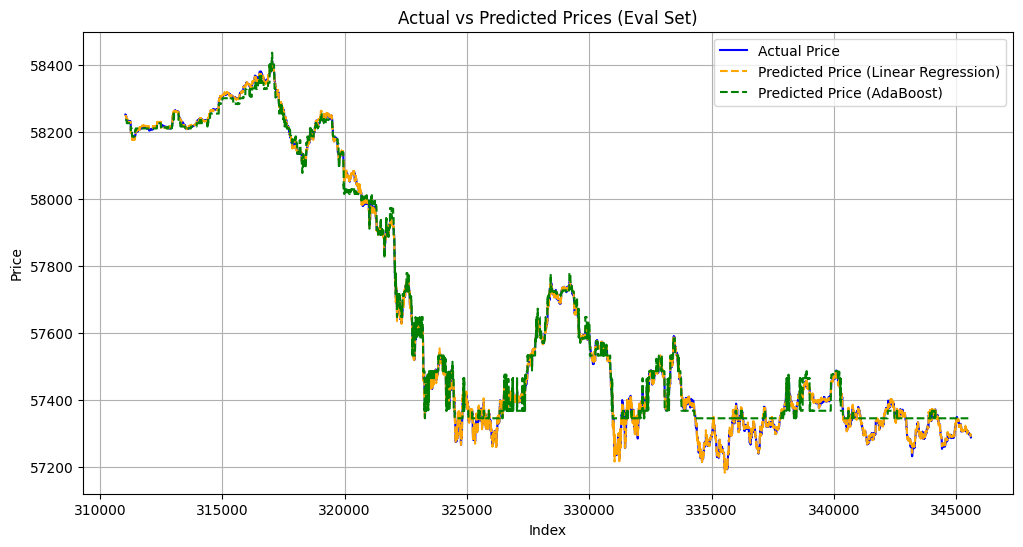

In [10]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(eval_data.index, y_eval, label="Actual Price", color="blue")
plt.plot(eval_data.index, eval_data["predicted_lr"], label="Predicted Price (Linear Regression)", color="orange", linestyle="--")
plt.plot(eval_data.index, eval_data["predicted_adaboost"], label="Predicted Price (AdaBoost)", color="green", linestyle="--")
plt.title("Actual vs Predicted Prices (Eval Set)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()
